In [59]:
import sortednp as snp
import numpy as np
from numba import njit
from numba.typed import List

@njit
def intersect_sorted_array(A, B):
  """
  Returns the sorted intersection of A and B
  - Assumes A and B are sorted
  - Assumes A and B each have no duplicates
  """
  i = 0
  j = 0
  intersection = List()

  while i < len(A) and j < len(B):
      if A[i] == B[j]:
          intersection.append(A[i])
          i += 1
          j += 1
      elif A[i] < B[j]:
          i += 1
      else:
          j += 1
  return np.asarray(intersection)

def native_intersect(A, B):
  return set(A).intersection(B)

def numpy_intersect(A, B):
  return np.intersect1d(A, B, assume_unique=True)

# Implement my own assume_unique=True https://github.com/numba/numba/issues/7784
@njit
def numba_numpy_intersect1d(A, B):
    aux = np.concatenate((A, B))
    aux.sort()

    mask = aux[1:] == aux[:-1]
    int1d = aux[:-1][mask]
    
    return int1d

def snp_intersect(A, B):
  return snp.intersect(A, B)

In [60]:
benchmarks = {
  'intersect_sorted_array': {},
  'native_intersect': {},
  'numpy_intersect': {},
  'numba_numpy_intersect1d': {},
  'snp_intersect': {}
}

for n in range(0, 100000, 10000):
  # Unique, because extents are unique
  test_A = np.unique(np.sort(np.random.randint(0, n, n)))
  test_B = np.unique(np.sort(np.random.randint(0, n, n)))

  # Run all functions first to eliminate the effect of compilation
  intersect_sorted_array(test_A, test_B)
  numba_numpy_intersect1d(test_A, test_B)
  native_intersect(test_A, test_B)
  numpy_intersect(test_A, test_B)
  snp_intersect(test_A, test_B)

  benchmarks['intersect_sorted_array'][n] = %timeit -o intersect_sorted_array(test_A, test_B)
  benchmarks['numba_numpy_intersect1d'][n] = %timeit -o numba_numpy_intersect1d(test_A, test_B)
  benchmarks['native_intersect'][n] = %timeit -o native_intersect(test_A, test_B)
  benchmarks['numba_numpy_intersect1d'][n] = %timeit -o numpy_intersect(test_A, test_B)
  benchmarks['snp_intersect'][n] = %timeit -o snp_intersect(test_A, test_B)

803 ns ± 23.7 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
867 ns ± 26 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
1.24 µs ± 11.6 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
3.2 µs ± 60.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
365 ns ± 6.55 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
127 µs ± 1.85 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
396 µs ± 10.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
909 µs ± 52.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
418 µs ± 9.39 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
103 µs ± 21.6 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
265 µs ± 7.75 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
857 µs ± 13 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.68 ms ± 12.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1 ms ± 21.9 µs per loop (mean ± s

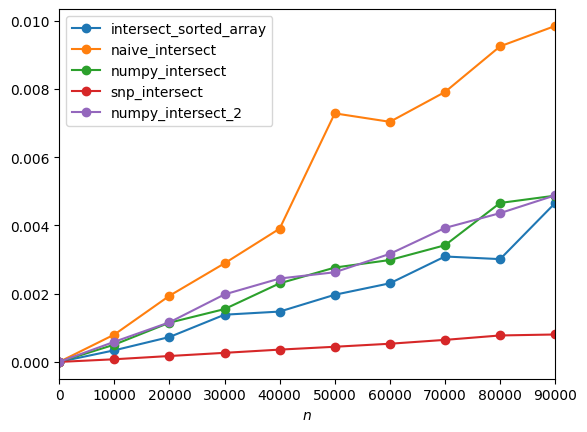

In [55]:
import matplotlib.pyplot as plt

ns_to_plot = list(range(0, 100000, 10000))
for label, time_result in benchmarks.items():
  plt.plot(ns_to_plot, [time_result[n].average for n in ns_to_plot], marker='o', label=label)

plt.xlim(ns_to_plot[0], ns_to_plot[-1])
plt.xlabel('$n$')
plt.legend()

plt.show()